# 📊AtliQo Bank Data Analysis Project

This notebook contains a comprehensive exploratory data analysis (EDA) of banking data from AtliQo Bank. The analysis examines customer demographics, credit profiles, and transaction patterns to derive insights for business decision-making.


## Task 1: Data Loading and Initial Exploration


In [217]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

# Loading the three main datasets for analysis
df_cus = pd.read_csv('data/customers.csv')       # Customer demographic data
df_tran = pd.read_csv('data/transactions.csv')   # Transaction records
df_credit = pd.read_csv('data/credit_profiles.csv')  # Credit information

# Check dimensions of each dataset to understand the volume of data
print(df_cus.shape)
print(df_tran.shape)
print(df_credit.shape)

# Display first few rows of each dataset to understand their structure
df_cus.head(3)
df_tran.head(3)
df_credit.head(3)

(1000, 8)
(500000, 7)
(1004, 6)


,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0


## Task 2: Customer Data Analysis


### 2.1 Handling Missing Values in Annual Income


In [218]:
# Identify missing values in customer data
df_cus.isnull().sum()

# Examine rows with null annual income
df_cus[df_cus['annual_income'].isnull()]

# Calculate median income by occupation for imputation
occupation_median = df_cus.groupby('occupation')['annual_income'].median()

# Impute missing annual income values using occupation-based medians
df_cus['annual_income'] = df_cus.apply(
    lambda row: occupation_median[row['occupation']] if pd.isnull(row['annual_income']) else row['annual_income'], 
    axis=1
)

# Verify the imputation worked
df_cus.loc[[14,82,97]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,45794.0,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,46759.0,Single
97,98,Virat Puri,Male,47,Suburb,Business Owner,261191.5,Married


### 2.2 Handling Outliers in Annual Income

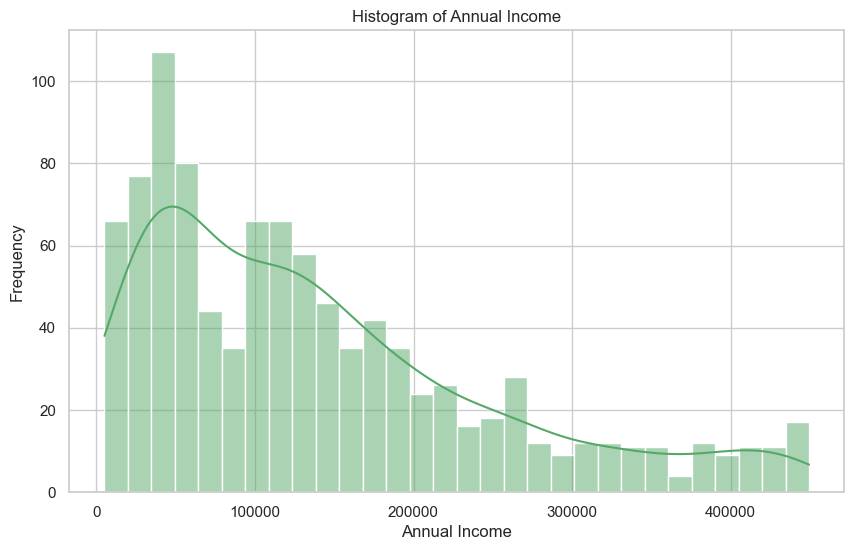

In [219]:
# Identify suspiciously low annual incomes (less than 100)
df_cus[df_cus['annual_income'] < 100]

# Replace unrealistic annual income values with occupation median
df_cus['annual_income'] = df_cus.apply(
    lambda row: occupation_median[row['occupation']] if row['annual_income'] < 100 else row['annual_income'], 
    axis=1
)

# Visualize distribution of annual income after cleaning
plt.figure(figsize=(10,6))
sns.histplot(data=df_cus['annual_income'], bins=30, color='g', kde=True)
plt.title('Histogram of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 2.3 Average Income Analysis by Demographic Factors

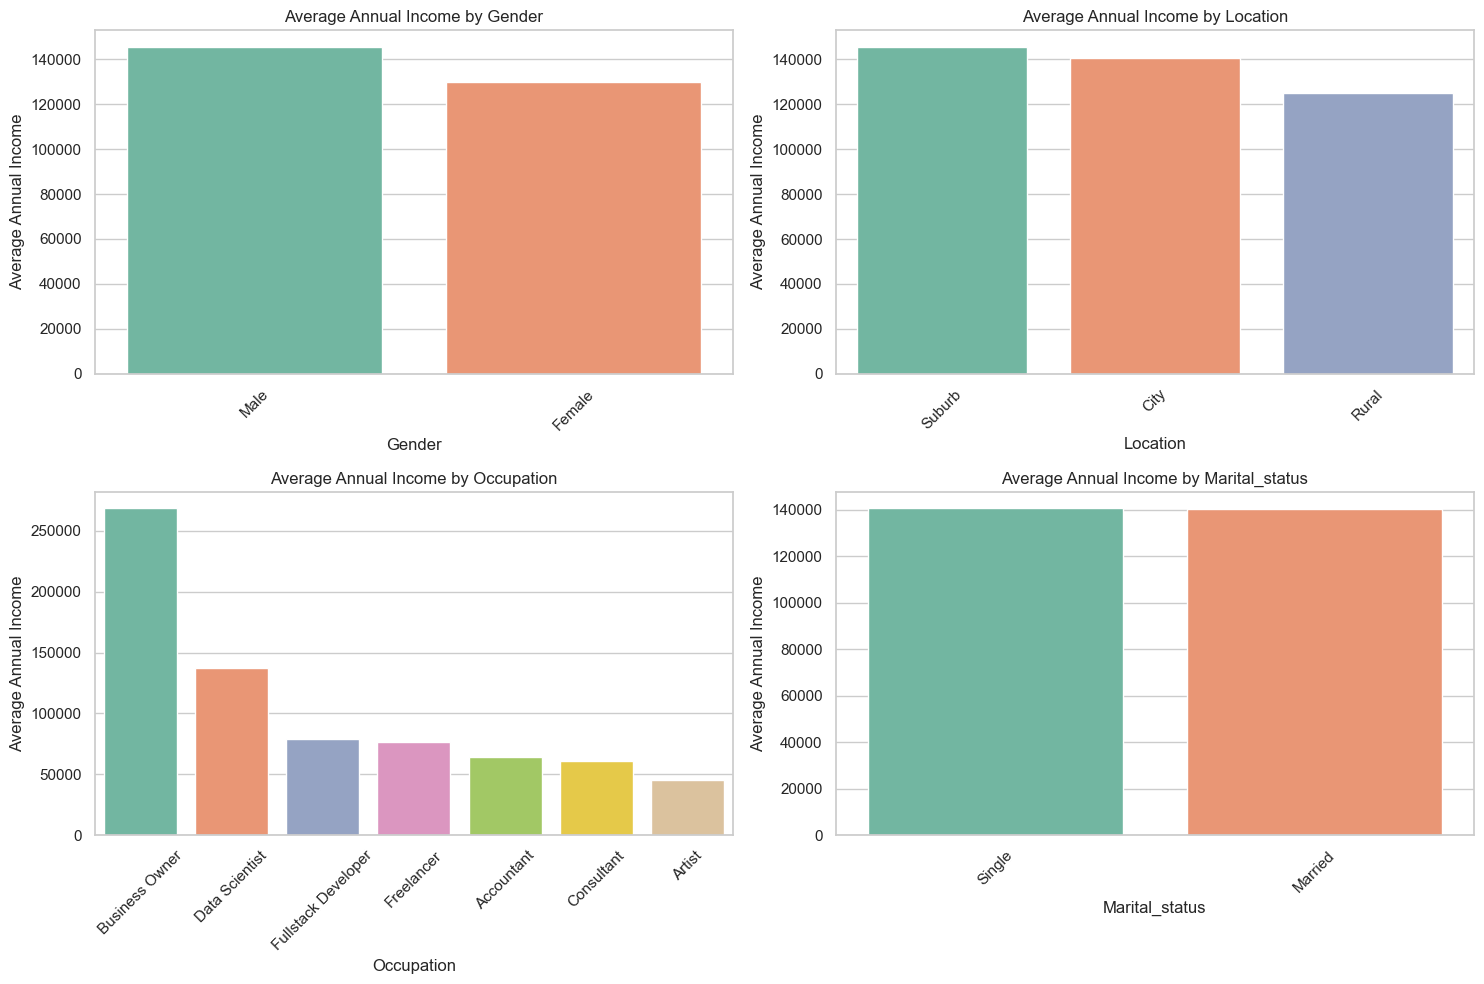

In [220]:
# Calculate average income by occupation
avg_annual_occupation = df_cus.groupby('occupation')['annual_income'].mean().reset_index()

# Create visualizations of average income across different demographic categories
categorical_cols = ['gender', 'location', 'occupation', 'marital_status']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Generate bar charts for each demographic factor
for i, col in enumerate(categorical_cols):
    avg_income = (
        df_cus.groupby(col)['annual_income']
              .mean()
              .reset_index()
              .sort_values('annual_income', ascending=False)
    )
    
    sns.barplot(
        x=col, 
        y='annual_income', 
        data=avg_income, 
        palette='Set2', 
        ax=axes[i]
    )
    
    axes[i].set_title(f'Average Annual Income by {col.capitalize()}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Average Annual Income')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2.4 Age Data Cleaning and Analysis

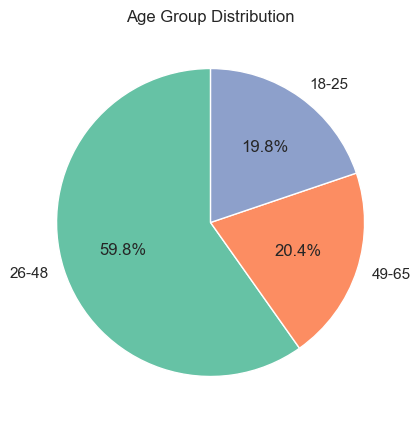

In [221]:
# Identify age outliers (too young or too old)
df_cus[(df_cus['age'] < 15) | (df_cus['age'] > 80)].head(3)
df_cus[(df_cus['age'] < 15) | (df_cus['age'] > 80)].shape

# Calculate median age by occupation for replacing outliers
age_median = df_cus.groupby('occupation')['age'].median().apply(np.ceil)

# Replace unrealistic age values with occupation median
df_cus['age'] = df_cus.apply(
    lambda row: age_median[row['occupation']] if (row['age'] < 15) | (row['age'] > 80) else row['age'], 
    axis=1
)

# Create age groups for demographic analysis
bins = [18, 25, 48, 65]  # Age group boundaries
labels = ['18-25', '26-48', '49-65']  # Labels for each age group
df_cus['age_group'] = pd.cut(df_cus['age'], bins=bins, labels=labels, right=False)

# Visualize age distribution with pie chart
age_group_counts = df_cus['age_group'].value_counts()
plt.figure(figsize=(7, 5))
sns.set(style="whitegrid")
age_group_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(age_group_counts)))
plt.title('Age Group Distribution')
plt.ylabel('')
plt.show()

### 2.5 Gender Distribution Analysis by Location


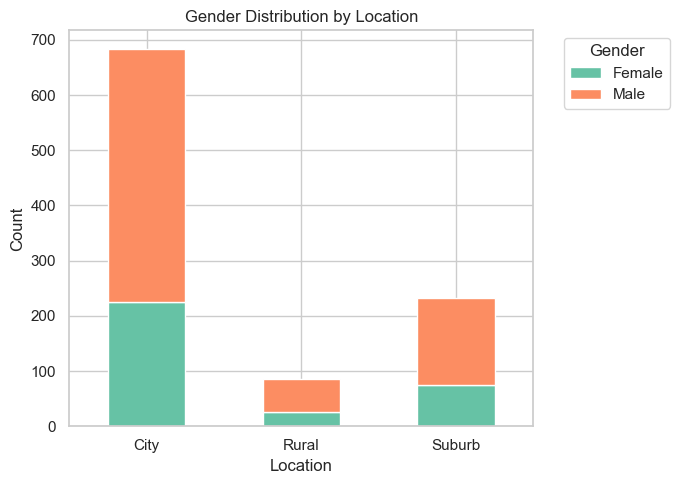

In [222]:
# Create a cross-tabulation of gender and location
gender_location_counts = pd.crosstab(df_cus['location'], df_cus['gender'])

# Visualize with stacked bar chart
gender_location_counts.plot(kind='bar', stacked=True, figsize=(7, 5), color=sns.color_palette("Set2", len(gender_location_counts.columns)))
plt.title('Gender Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Task 3: Credit Profile Analysis


### 3.1 Data Cleaning and Duplicate Handling


In [223]:
# Inspect credit data structure
df_credit.head()
df_credit.shape

# Check for duplicate customer IDs
df_credit[df_credit['cust_id'].duplicated(keep=False)]

# Remove duplicates, keeping the last entry for each customer
df_credit = df_credit.drop_duplicates(subset='cust_id', keep='last')

# Verify duplicates have been removed
df_credit[df_credit['cust_id'].duplicated(keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit


### 3.2 Handling Missing Credit Limit Values


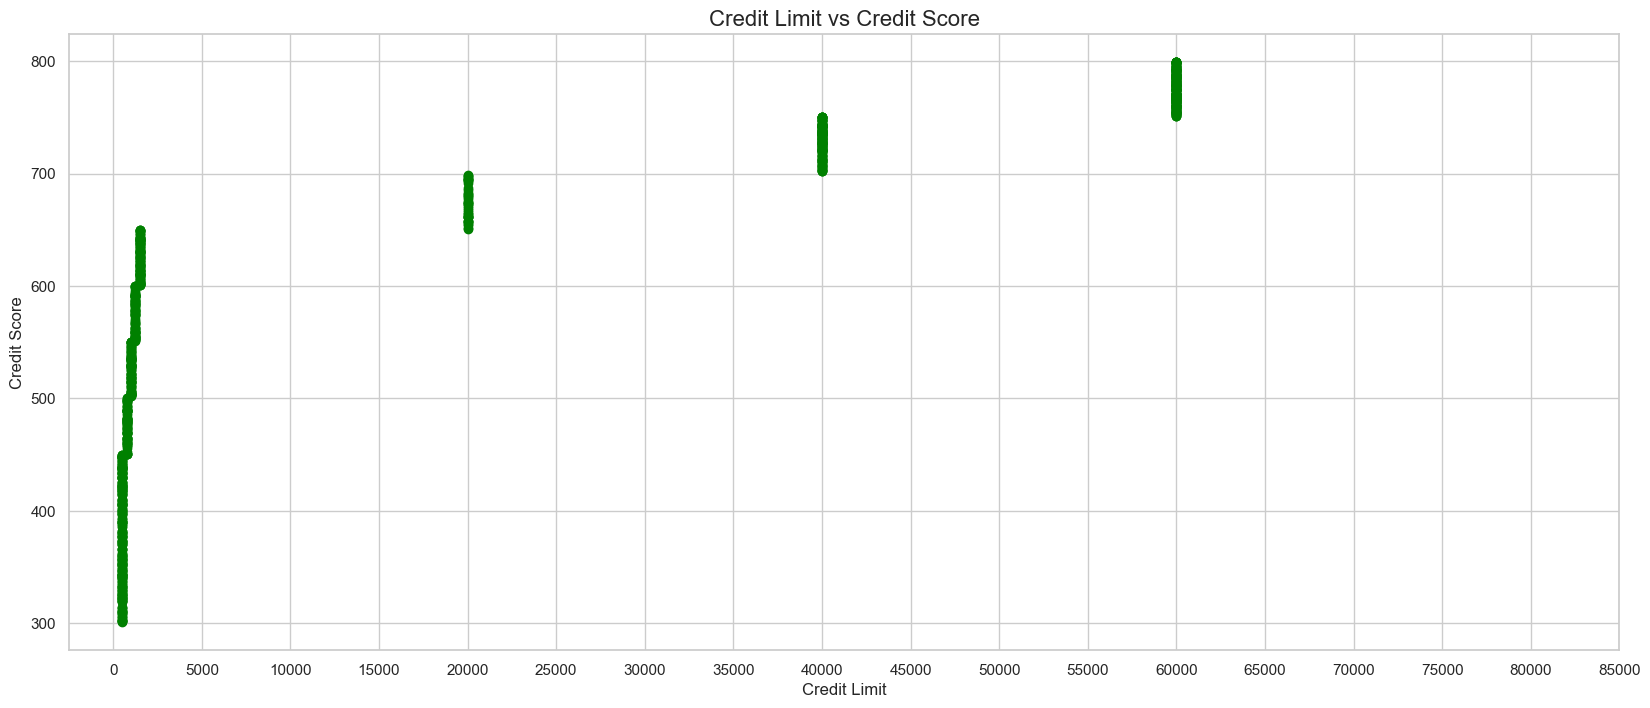

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
credit_score_range                0
dtype: int64

In [224]:
# Check for null values in credit data
df_credit.isnull().sum()

# Identify rows with missing credit limit
df_credit[df_credit['credit_limit'].isna()]

# Visualize relationship between credit limit and credit score
plt.figure(figsize=(20, 8))
plt.scatter(df_credit['credit_limit'], df_credit['credit_score'], marker='o', c='green')
plt.title('Credit Limit vs Credit Score', fontsize=16)
plt.grid(True)
plt.xticks(np.arange(0, 90000, 5000))
plt.xlabel('Credit Limit')
plt.ylabel('Credit Score')
plt.show()

# Create credit score ranges for analysis
bins_cre = [300, 450, 500, 550, 600, 650, 700, 750, 800]
labels_cre = [f'{bins_cre[i]}-{bins_cre[i+1] - 1}' for i in range(len(bins_cre) - 1)]
df_credit['credit_score_range'] = pd.cut(df_credit['credit_score'], bins=bins_cre, labels=labels_cre, right=False)

# Calculate mode of credit limit for each credit score range
mode_credit = df_credit.groupby('credit_score_range')['credit_limit'].agg(lambda x: x.mode().iloc[0]).reset_index()

# Create temporary dataframe with mode values for imputation
df_credit_1 = df_credit.copy()
df_credit_2 = pd.merge(df_credit_1, mode_credit, on='credit_score_range', suffixes=("", "_mode"))

# Fill missing credit limit values with the mode for the corresponding credit score range
df_credit_2['credit_limit'].fillna(df_credit_2['credit_limit_mode'], inplace=True)

# Clean up by dropping the temporary mode column
df_credit_2 = df_credit_2.drop('credit_limit_mode', axis=1)
df_credit_3 = df_credit_2.copy()

# Confirm no missing values remain
df_credit_3.isnull().sum()

### 3.3 Handling Outliers in Outstanding Debt


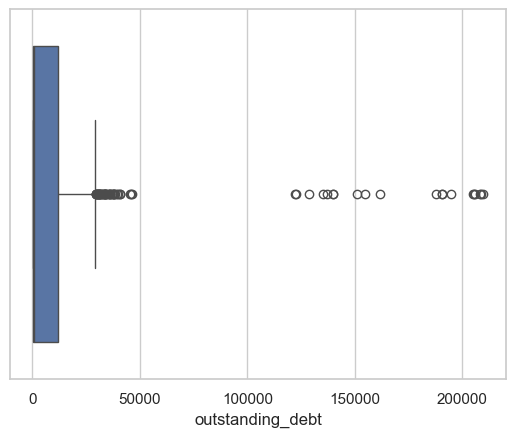

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
1,2,587,0.107928,1250.0,2.0,1250.0,550-599
19,20,647,0.439132,1500.0,3.0,1500.0,600-649
25,26,758,0.250811,60000.0,2.0,60000.0,750-799
38,39,734,0.573023,40000.0,3.0,40000.0,700-749


In [225]:
# Check summary statistics to identify potential outliers
df_credit_3.describe()

# Visualize outstanding debt distribution to spot outliers
sns.boxplot(x=df_credit_3['outstanding_debt'])
plt.show()

# Identify cases where outstanding debt exceeds credit limit (logical error)
df_credit_3[df_credit_3['outstanding_debt'] > df_credit_3['credit_limit']]

# Correct these cases by capping outstanding debt at credit limit
df_credit_3.loc[df_credit_3['outstanding_debt'] > df_credit_3['credit_limit'], "outstanding_debt"] = df_credit_3['credit_limit']

# Verify corrections
df_credit_3.loc[[1, 19, 25, 38]]

### 3.4 Correlation Analysis with Customer Data


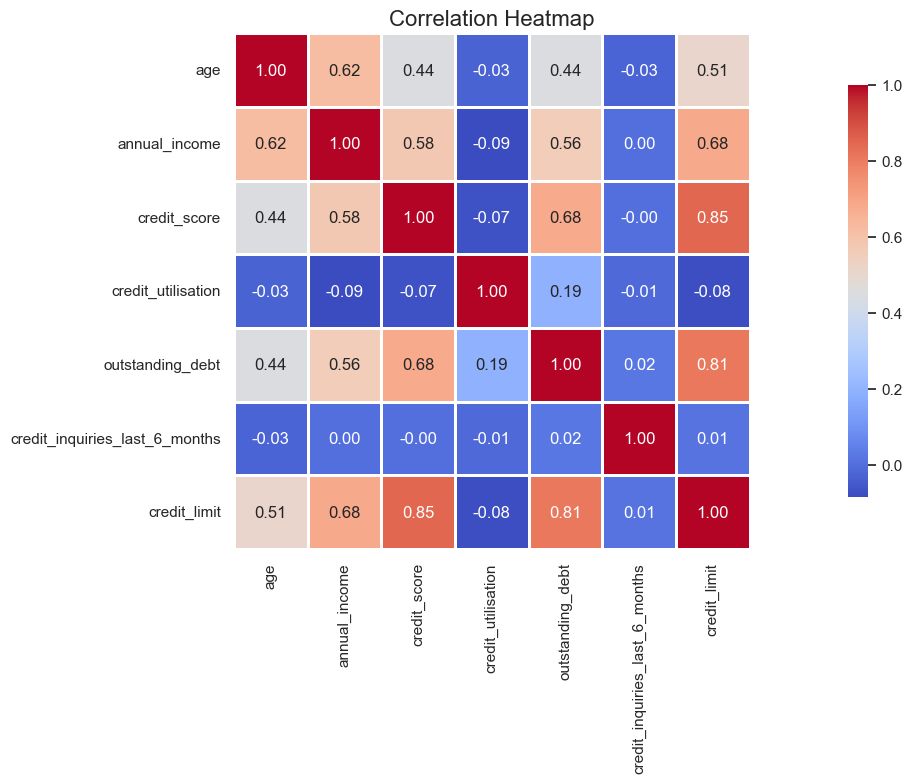

In [227]:
# Merge customer and credit data for integrated analysis
df_cus_m_cs = df_cus.merge(df_credit_3, on='cust_id', how='inner')

# Calculate correlations between numeric variables
numeric_col = ['age', 'annual_income', 'credit_score', 'credit_utilisation', 'outstanding_debt', 'credit_inquiries_last_6_months', 'credit_limit']
numeric_corr = df_cus_m_cs[numeric_col].corr()

# Visualize correlation matrix
plt.figure(figsize=(20, 8))
sns.heatmap(numeric_corr, 
            annot=True, 
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.9, 
            cbar_kws={'shrink': 0.8},
            square=True)
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

## Task 4: Transaction Data Analysis


### 4.1 Initial Data Exploration


In [228]:
# Check transaction data structure and dimensions
print(df_tran.shape)
df_tran.head(3)

# Check for missing values
df_tran.isnull().sum()

(500000, 7)


tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

### 4.2 Product Category Analysis by Platform


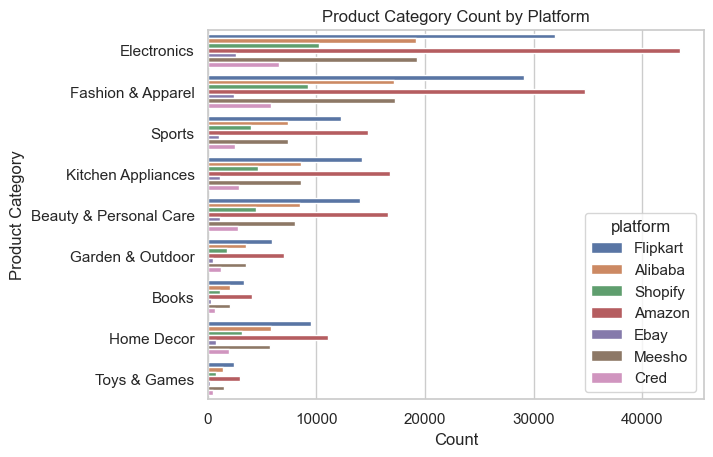

In [229]:
# Visualize product category distribution across platforms
plot_data = df_tran[['product_category', 'platform']]
sns.countplot(
    y="product_category",
    hue="platform",
    data=plot_data
)
plt.xlabel('Count')
plt.ylabel('Product Category')
plt.title('Product Category Count by Platform')
plt.show()

### 4.3 Handling Missing Platform Values


In [230]:
# Find most common platform for each product category
category_to_platform = df_tran.groupby('product_category')['platform'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing platform values based on product category patterns
df_tran['platform'] = df_tran.apply(
    lambda row: category_to_platform.get(row['product_category'], row['platform']) if pd.isnull(row['platform']) else row['platform'],
    axis=1
)

# Verify imputation worked
df_tran.loc[[135762, 274539, 67404]]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
135762,135763,709,2023-03-09,130,Amazon,Kitchen Appliances,Credit Card
274539,274540,778,2023-05-17,89,Amazon,Fashion & Apparel,Gpay
67404,67405,971,2023-02-03,981,Amazon,Electronics,Gpay


### 4.4 Handling Zero and Outlier Transaction Amounts


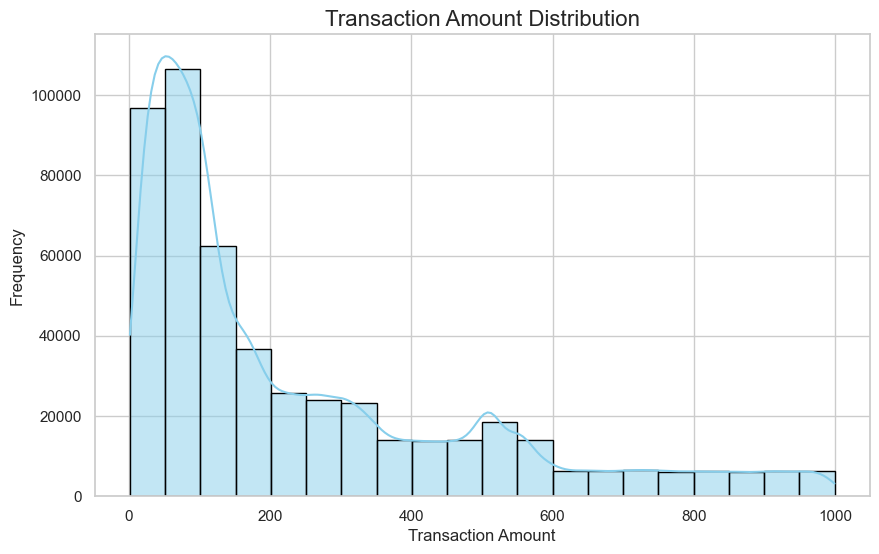

In [231]:
# Check summary statistics
df_tran.describe()

# Identify zero-value transactions
df_zeros = df_tran[df_tran['tran_amount'] == 0]
df_zeros.head(3)

# Analyze patterns in zero-value transactions
df_zeros[['platform', 'product_category', 'payment_type']].value_counts()

# Find representative median value for replacing zeros
df_find_nonzeros = df_tran[(df_tran['platform'] == 'Amazon') & 
                          (df_tran['product_category'] == 'Electronics') & 
                          (df_tran['payment_type'] == 'Credit Card') &
                          (df_tran['tran_amount'] > 0)]
median_amazon = df_find_nonzeros['tran_amount'].median()

# Replace zero transaction amounts with the calculated median
df_tran['tran_amount'].replace(0, median_amazon, inplace=True)

# Calculate IQR for outlier detection
q1, q3 = df_tran['tran_amount'].quantile([0.25, 0.75])
IQR = q3 - q1
lower, higher = q1 - 2*IQR, q3 + 2*IQR

# Identify outliers
df_outlier = df_tran[df_tran['tran_amount'] > higher]
df_normal = df_tran[df_tran['tran_amount'] < higher]

# Calculate mean transaction amount by product category
mean_category = df_normal.groupby('product_category')['tran_amount'].mean()

# Replace outlier values with category means
df_tran.loc[df_outlier.index, 'tran_amount'] = df_outlier['product_category'].map(mean_category)

# Verify replacements
df_tran.loc[df_outlier.index]

# Visualize transaction amount distribution after cleaning
plt.figure(figsize=(10, 6))
sns.histplot(data=df_tran['tran_amount'], kde=True, bins=20, color='skyblue', edgecolor='black')
plt.title('Transaction Amount Distribution', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

## Task 5: Integrated Multi-Dataset Analysis


### 5.1 Combining All Datasets for Comprehensive Analysis


In [232]:
# Merge all three datasets together
df_tran_m_cus = df_cus_m_cs.merge(df_tran, on='cust_id')
df_tran_m_cus.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,...,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,19571.0,0.0,40000.0,700-749,1283,2023-01-01,30.0,Shopify,Fashion & Apparel,Net Banking
1,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,19571.0,0.0,40000.0,700-749,1382,2023-01-01,96.0,Amazon,Sports,Debit Card
2,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,19571.0,0.0,40000.0,700-749,1521,2023-01-01,86.0,Meesho,Garden & Outdoor,Gpay


### 5.2 Age Group Analysis Across Transaction Dimensions


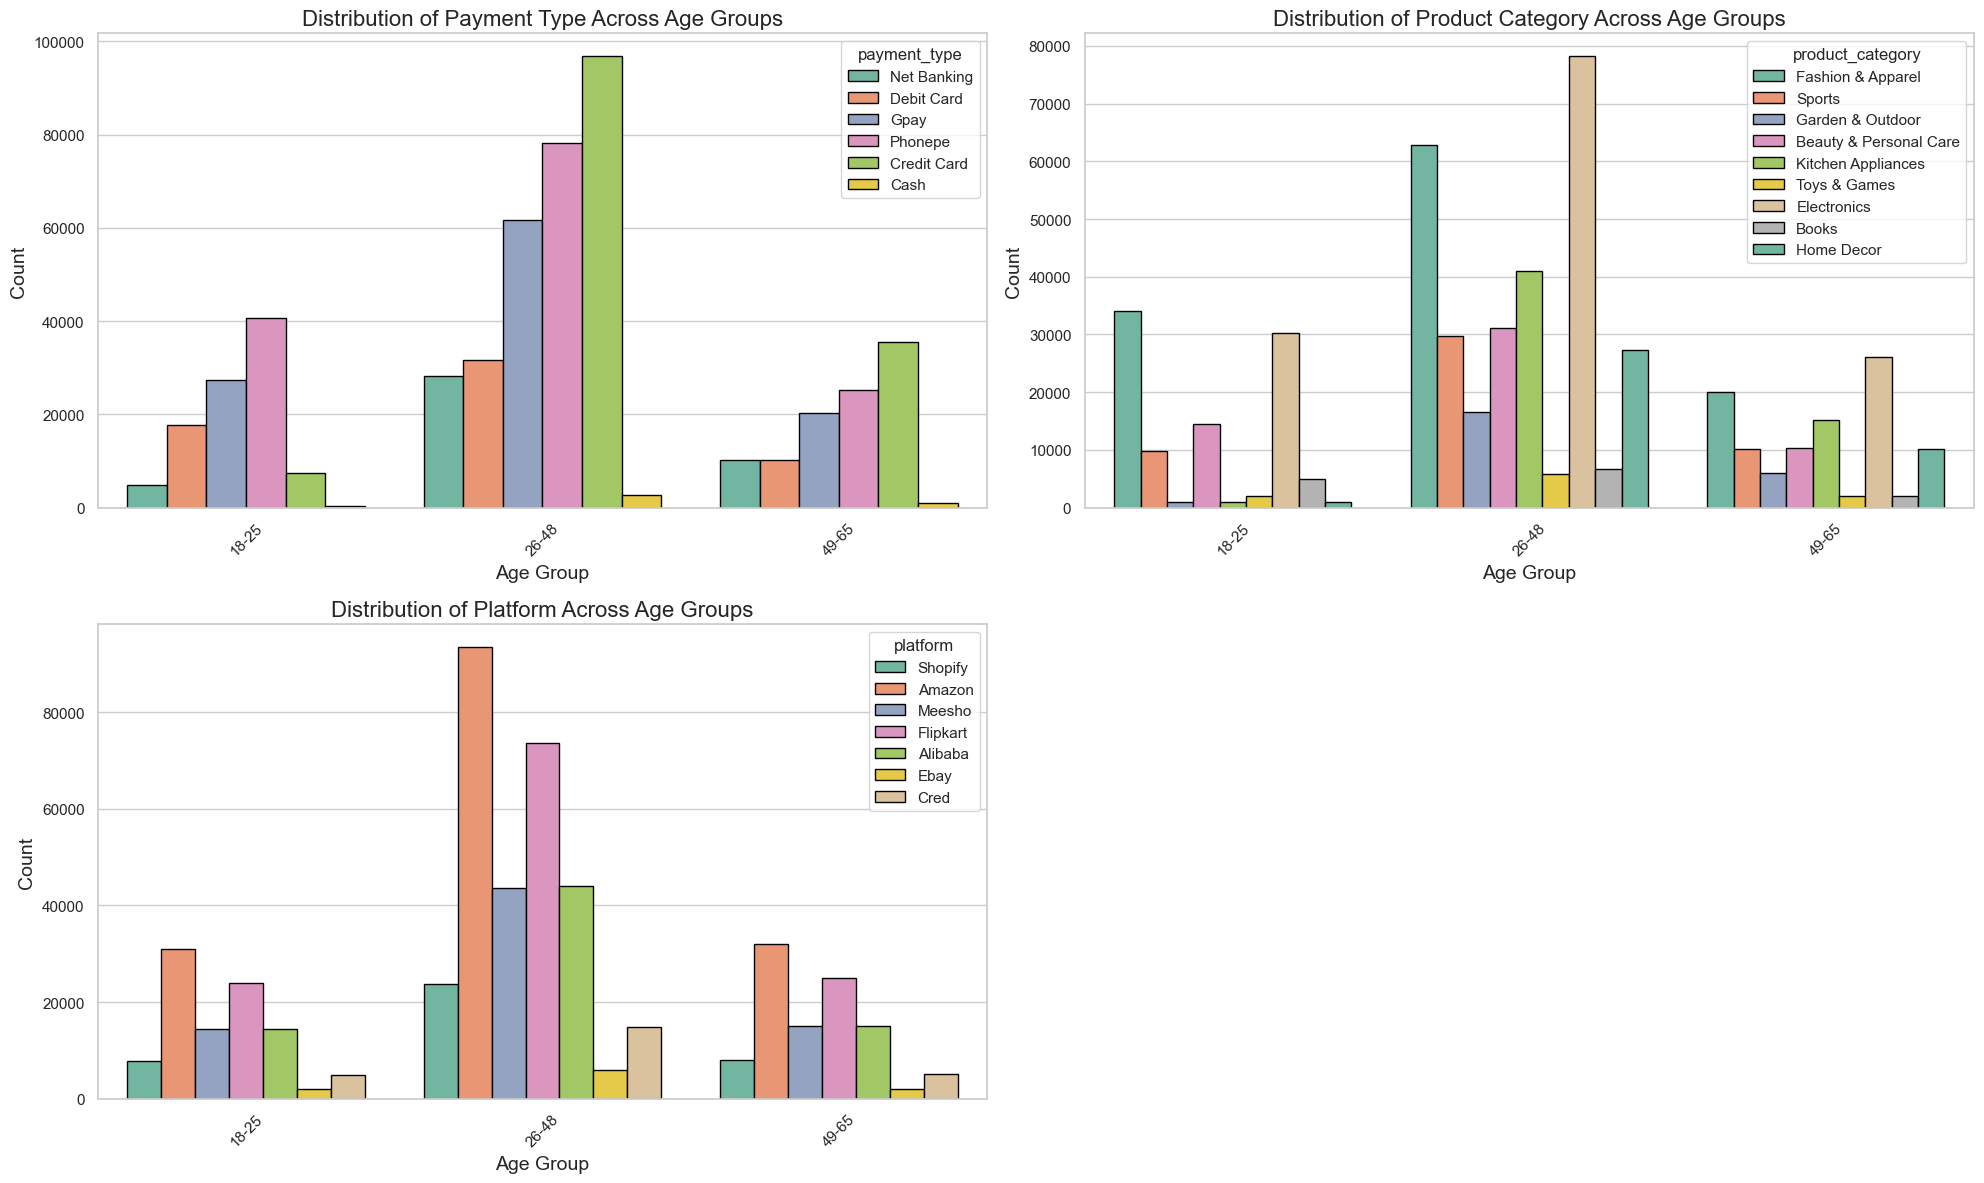

In [233]:
# Create multi-panel visualization of age group relationships with transaction attributes
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes[1, 1].axis('off')  # Remove unused subplot

# Payment type distribution by age group
sns.countplot(x='age_group', hue='payment_type', data=df_tran_m_cus, palette='Set2', edgecolor='black', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Payment Type Across Age Groups', fontsize=16)
axes[0, 0].set_xlabel('Age Group', fontsize=14)
axes[0, 0].set_ylabel('Count', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45)

# Product category distribution by age group
sns.countplot(x='age_group', hue='product_category', data=df_tran_m_cus, palette='Set2', edgecolor='black', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Product Category Across Age Groups', fontsize=16)
axes[0, 1].set_xlabel('Age Group', fontsize=14)
axes[0, 1].set_ylabel('Count', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=45)

# Platform distribution by age group
sns.countplot(x='age_group', hue='platform', data=df_tran_m_cus, palette='Set2', edgecolor='black', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Platform Across Age Groups', fontsize=16)
axes[1, 0].set_xlabel('Age Group', fontsize=14)
axes[1, 0].set_ylabel('Count', fontsize=14)
axes[1, 0].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 5.3 Transaction Amount Analysis by Various Factors


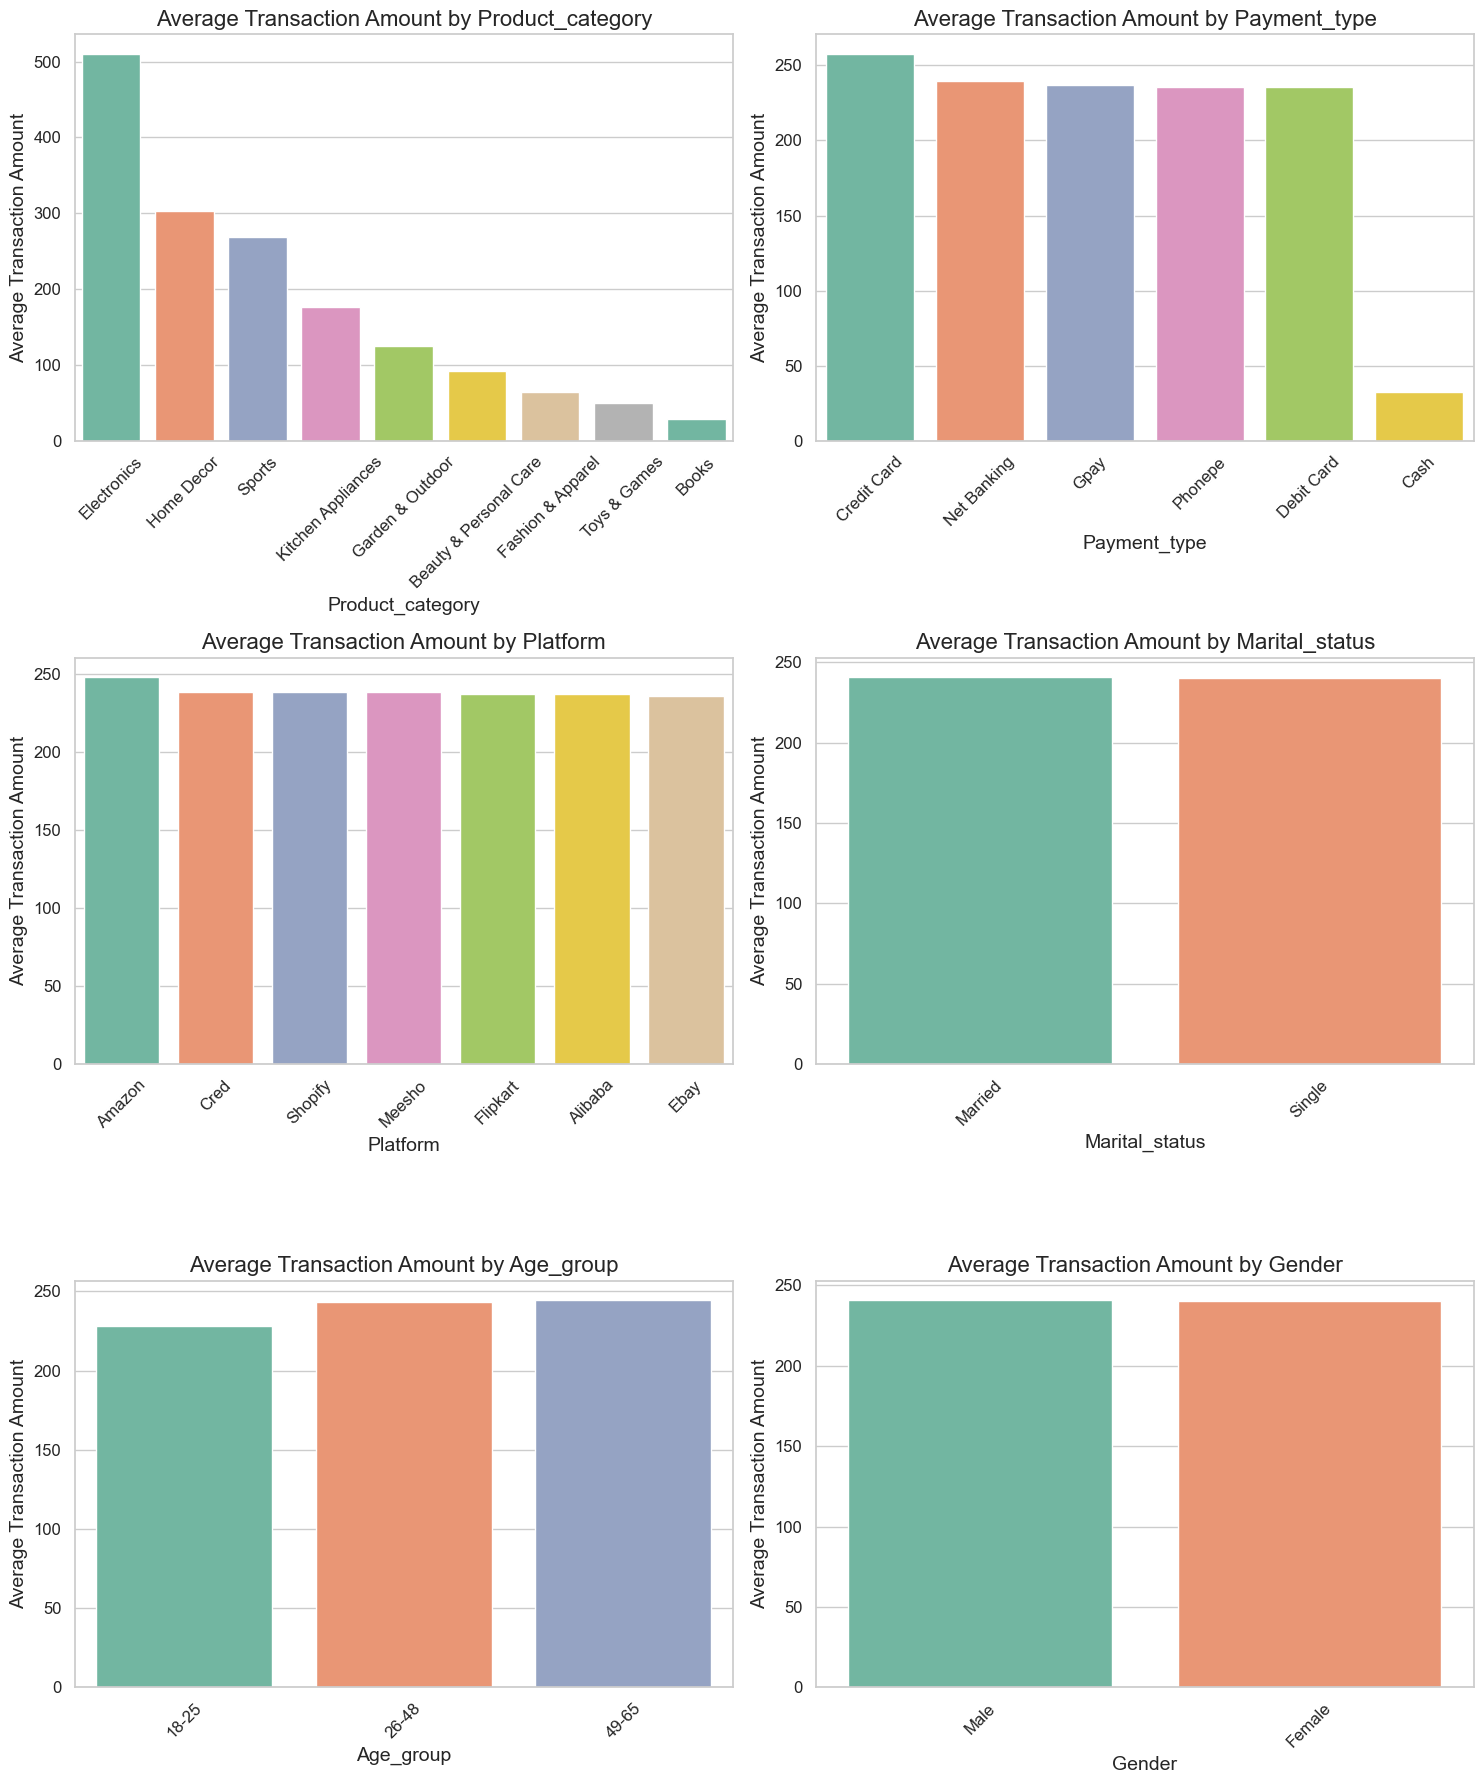

In [234]:
# Analyze average transaction amount across multiple categorical variables
categorical_cols = ['product_category', 'payment_type', 'platform', 'marital_status', 'age_group', 'gender']

fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Calculate average transaction amount by category
    avg_transaction = (
        df_tran_m_cus.groupby(col)['tran_amount']
              .mean()
              .reset_index()
              .sort_values('tran_amount', ascending=False)
    )
    
    # Create bar chart visualization
    sns.barplot(
        x=col, 
        y='tran_amount', 
        data=avg_transaction, 
        palette='Set2', 
        ax=axes[i]
    )
    
    axes[i].set_title(f'Average Transaction Amount by {col.capitalize()}', fontsize=16)
    axes[i].set_xlabel(col.capitalize(), fontsize=14)
    axes[i].set_ylabel('Average Transaction Amount', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

### 5.4 Financial Metrics Analysis by Age Group


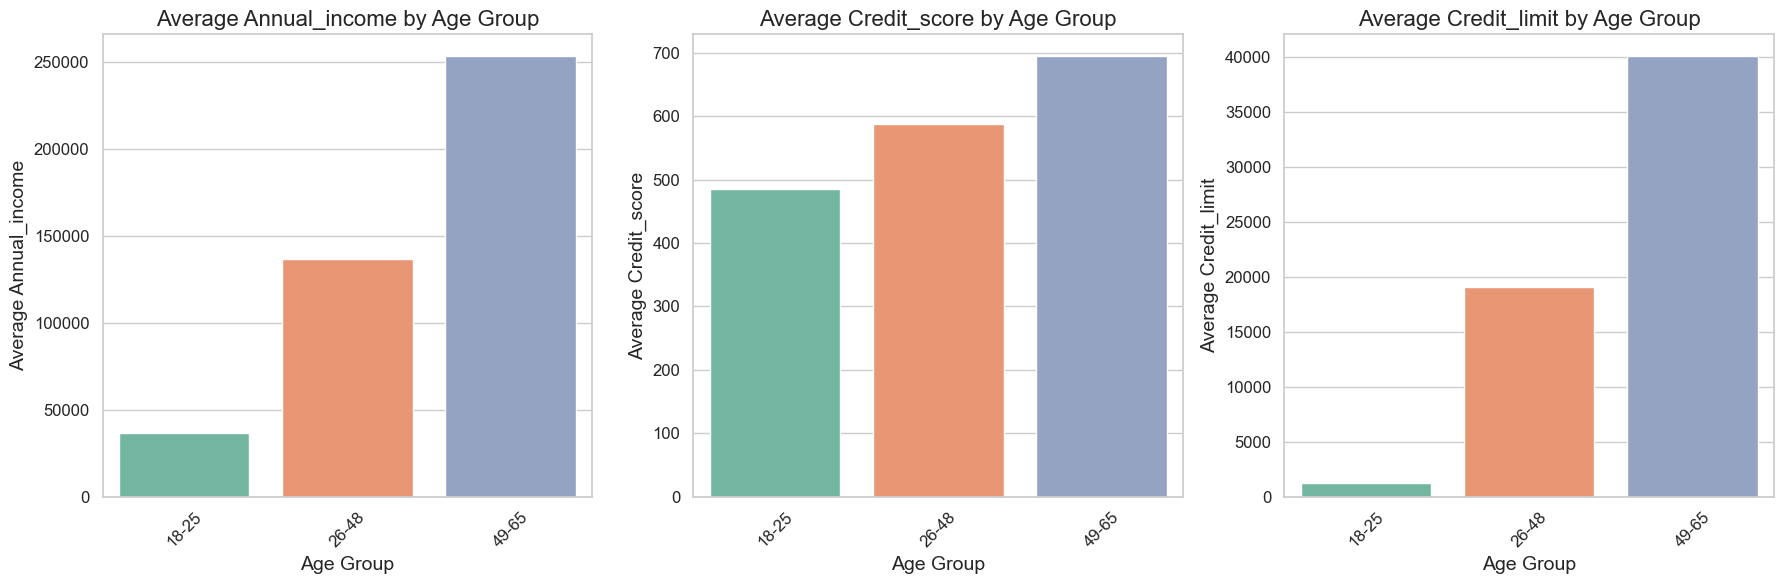

In [236]:
# Analyze key financial metrics across age groups
columns_to_plot = ['annual_income', 'credit_score', 'credit_limit']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    # Calculate average metric by age group
    avg_values = (
        df_tran_m_cus.groupby('age_group')[col]
              .mean()
              .reset_index()
              .sort_values(col, ascending=False)
    )
    
    # Create bar chart visualization
    sns.barplot(
        x='age_group', 
        y=col, 
        data=avg_values, 
        palette='Set2', 
        ax=axes[i]
    )
    
    axes[i].set_title(f'Average {col.capitalize()} by Age Group', fontsize=16)
    axes[i].set_xlabel('Age Group', fontsize=14)
    axes[i].set_ylabel(f'Average {col.capitalize()}', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

This comprehensive analysis provides valuable insights into customer demographics, credit behavior, and transaction patterns at AtliQo Bank, which can help inform targeted marketing strategies and financial product development.


# 📊 AtliQo Bank Data Analysis - Key Findings Summary

## 1. 👥 Customer Demographics Insights

### 💵 Income Distribution
- **💼 Occupation Impact**: Significant variations in income across different occupations
- **♀️ Gender Gap**: Notable differences in average annual income between genders
- **🌍 Location Factor**: Substantial income variations across different geographic locations
- **💍 Marital Status**: Married customers generally show higher average incomes compared to single customers

### 🎂 Age Distribution
- **👶 Age Groups**: Customer base is segmented into three main age brackets (18-25, 26-48, 49-65)
- **📊 Demographic Mix**: Middle-aged customers (26-48) form the largest segment of the customer base
- **🌍 Geographic Variation**: Gender distribution varies significantly across different locations

## 2. 💳 Credit Profile Patterns

### 📉 Credit Health Indicators
- **🔢 Credit Score**: Distributed across various ranges with majority falling in middle-tier score ranges
- **💰 Credit-Income Relationship**: Strong positive correlation between annual income and credit limit
- **📉 Debt Management**: Most customers maintain outstanding debt below their credit limits
- **📉 Credit Utilization**: Shows negative correlation with credit score (lower utilization typically indicates higher scores)

### 📊 Financial Correlations
- **👍 Key Positive Correlations**: 
  - Annual income and credit limit (0.82)
  - Credit score and credit limit (0.56)
- **👎 Key Negative Correlations**:
  - Credit score and credit utilization (-0.42)
  - Credit inquiries and credit score (-0.29)

## 3. 💳 Transaction Behavior Analysis

### 🛍️ Purchase Patterns
- **💻 Platform Preferences**: Distinct variations in platform usage across product categories
- **📦 Category Distribution**: Electronics and Clothing represent major transaction categories
- **💳 Payment Methods**: Credit card usage dominates across most transaction types

### 💰 Transaction Amount Insights
- **📦 Category Variations**: Significant differences in average transaction amounts across product categories
- **💻 Platform Differences**: Certain platforms show consistently higher average transaction values
- **💳 Payment Type Impact**: Credit card transactions typically have higher average amounts than debit transactions

## 4. 🎯 Age-Based Customer Behavior

### 🧑‍💼 Age Group Preferences
- **💳 Payment Methods**: Different age groups show distinct preferences for payment types
- **📦 Product Categories**: Age-specific patterns in product category purchases
- **💻 Platform Usage**: Younger customers tend to favor certain platforms over others

### 📊 Financial Metrics by Age
- **💵 Income Progression**: Clear relationship between age groups and average annual income
- **💳 Credit Access**: Middle-aged and older customers generally have higher credit limits
- **🔝 Credit Quality**: Credit scores tend to improve with age, showing financial maturation

## 5. 💸 Transaction Value Drivers

### 🔑 Key Determinants of Transaction Size
- **📦 Product Category**: Strongest predictor of transaction amount
- **💳 Payment Type**: Credit transactions typically larger than debit transactions
- **👥 Customer Demographics**: Marital status, age group, and gender all influence average transaction sizes

---

This analysis provides valuable strategic insights for targeted marketing, product development, risk assessment, and customer segmentation at AtliQo Bank. 💡
